In [1]:
from efficientnet_pytorch import EfficientNet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

model = EfficientNet.from_name('efficientnet-b2')

model_name = 'efficientnet-b2'
image_size = EfficientNet.get_image_size(model_name)

image_size

model = EfficientNet.from_pretrained(model_name)


np.random.seed(30)


Loaded pretrained weights for efficientnet-b2


[BatchNorm2d(1408, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=1408, out_features=1000, bias=True)]

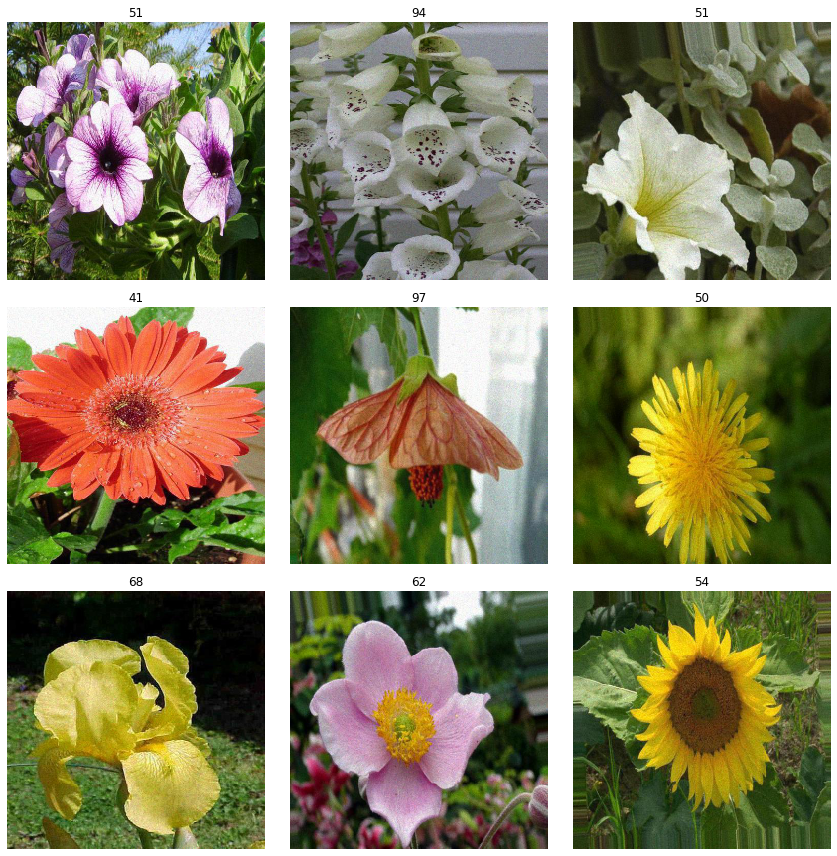

In [3]:
src = (ImageList.from_csv('', 'train-labels.csv', folder='train', suffix='.jpg')
       .split_by_rand_pct(0.2).label_from_df())

src.add_test_folder('test')

tfms=get_transforms()

data = (src.transform(([],[]),size=image_size)
        .databunch(bs=64).normalize(imagenet_stats))

data.show_batch(3,figsize=(12,12))

loss_func = LabelSmoothingCrossEntropy()

list(children(model))[-2:]





In [4]:
model.add_module('_fc',nn.Linear(1408, data.c))


RMSprop = partial(torch.optim.RMSprop)


learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')])


learn.model

learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:7]],
             [learn.model._blocks[7:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 261, 261]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 130, 130]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 132, 132]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 130, 130]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 130, 130]       0          False     
_________________________________________________

In [5]:
learn.load('b2-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
77,81,52,72,58
Path: .;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: CategoryList
23,58,51,90,83
Path: .;

Test: LabelList (2009 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), 

In [6]:
learn.metrics=[accuracy]

In [7]:
learn.validate()

[0.79038477, tensor(0.9995)]

In [10]:
lr = 1e-4

In [11]:
learn.fit_one_cycle(5,slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.797076,0.790015,0.999461,01:22
1,0.797111,0.790670,0.999461,01:21
2,0.795552,0.789167,0.999461,01:21
3,0.793934,0.788297,0.999191,01:21
4,0.792810,0.787911,0.999191,01:21


In [12]:
lr=1e-5

In [13]:
learn.fit_one_cycle(5,slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.793124,0.787724,0.999191,01:21
1,0.792552,0.787556,0.999191,01:21
2,0.792581,0.787552,0.999191,01:20
3,0.792309,0.787351,0.999191,01:21
4,0.792052,0.787489,0.999461,01:21


In [14]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

In [15]:
data.test_ds.items[0]


filenames=[]

str(os.path.basename(data.test_ds.items[0]))

for filename in data.test_ds.items:
    filenames.append(str(os.path.basename(filename)))

len(filenames)

filenames

labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred))+1)

submission = pd.DataFrame(
    {'image_id': filenames,
     'category': labelled_preds,
    })


submission['image_id'] = submission['image_id'].apply(lambda x:x.split('.')[0])


submission = submission.sort_values(by = ['image_id'], ascending = [True])


submission.head()

submission.to_csv('submission-6.csv',index=False)